## Using a Dataset to Investigate the Relationship Between High Cholesterol Levels and Risk of Heart Disease

### Adam Trainer, Matthew Zizek, Phoebe Qiu, Rikki Ye

## Introduction
Prior research has shown that several risk factors increase the prevalence of heart attacks and heart diseases, including age and cholesterol levels above 200 mg/dL (Karthick et al., 2022). Therefore, we will be using data from a valid data set to answer the following predictive question; “Can age and cholesterol levels be used to predict if an individual has a heat disease”. The UC Irvine (UCI) Machine Learning Repository contains the Cleveland heart disease dataset that will be used to answer our question (Janosi et al., 1988). The dataset is used by machine learning researchers to analyze algorithms by answering a variety of predictive questions including predicting heart diseases for patients using many health risk predictors.

## Preliminary exploratory data analysis

In [1]:
library(shiny)

In [2]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(repr)
library(RColorBrewer)
data <- read_csv("https://github.com/matthewzizek/dsci-100-project/raw/main/data/processed.cleveland.data") #loading data from original source

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [3]:
head (data)

63.0 1.0...2 1.0...3 145.0 233.0 1.0...6 2.0 150.0 0.0...9 2.3 3.0 0.0...12
1 67   1       4       160   286   0       2   108   1       1.5 2   3.0     
2 67   1       4       120   229   0       2   129   1       2.6 2   2.0     
3 37   1       3       130   250   0       0   187   0       3.5 3   0.0     
4 41   0       2       130   204   0       2   172   0       1.4 1   0.0     
5 56   1       2       120   236   0       0   178   0       0.8 1   0.0     
6 62   0       4       140   268   0       2   160   0       3.6 3   2.0     
  6.0 0
1 3.0 2
2 7.0 1
3 3.0 0
4 3.0 0
5 3.0 0
6 3.0 3

In [4]:
# Wrangle and cleans data from original format into necessary format
cleveland <- data |>
  select(1, 5, 14) |>
  rename(age = 1, chol = 2, diag = 3)

head(cleveland)

age chol diag
1 67  286  2   
2 67  229  1   
3 37  250  0   
4 41  204  0   
5 56  236  0   
6 62  268  3

Table 1. Cleveland dataset

In [5]:
# Create a new variable called diagnosis based on the condition
cleveland$diagnosis <- ifelse(cleveland$diag == 0, "no heart disease", "presence of heart disease")

# Print the updated data frame
print(cleveland)

# A tibble: 302 × 4
     age  chol  diag diagnosis                
   <dbl> <dbl> <dbl> <chr>                    
 1    67   286     2 presence of heart disease
 2    67   229     1 presence of heart disease
 3    37   250     0 no heart disease         
 4    41   204     0 no heart disease         
 5    56   236     0 no heart disease         
 6    62   268     3 presence of heart disease
 7    57   354     0 no heart disease         
 8    63   254     2 presence of heart disease
 9    53   203     1 presence of heart disease
10    57   192     0 no heart disease         
# ℹ 292 more rows


In [6]:
set.seed(1)

# Splitting the data frame into training and testing datasets
cleveland$diagnosis <- factor(cleveland$diagnosis)
cleveland_split <- initial_split(cleveland, prop = 0.75, strata = diagnosis)

cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

strong("Table 3: ")
head(cleveland_train)

# Creating a recipe
cleveland_recipe <- recipe(diagnosis ~ age + chol, data = cleveland_train)

strong("Table 5: ")
cleveland_recipe <- cleveland_recipe |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep() 

cleveland_recipe

#To scale and center the data, use the bake function to the unscaled data
scaled_cleveland <- bake(cleveland_recipe, cleveland_train)

head(scaled_cleveland)

Shiny tags cannot be represented in plain text (need html)

age chol diag diagnosis       
1 37  250  0    no heart disease
2 41  204  0    no heart disease
3 56  236  0    no heart disease
4 56  294  0    no heart disease
5 44  263  0    no heart disease
6 54  239  0    no heart disease

Shiny tags cannot be represented in plain text (need html)



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 226 data points and no incomplete rows.



── Operations 

• Scaling for: age, chol | Trained

• Centering for: age, chol | Trained



age         chol        diagnosis       
1 -1.90592238  0.07937336 no heart disease
2 -1.47301941 -0.80694830 no heart disease
3  0.15036674 -0.19037671 no heart disease
4  0.15036674  0.92715929 no heart disease
5 -1.14834218  0.32985557 no heart disease
6 -0.06608475 -0.13257312 no heart disease

In [7]:
# Creating a model specification to find the value of K with the best accuracy
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                            neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [8]:
# Perform 5-fold cross-validation
cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = diagnosis)

In [9]:
# Fitting the model
knn_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cleveland_vfold, grid = 10) |>
    collect_metrics()

knn_fit

neighbors .metric  .estimator mean      n std_err    .config              
1   2        accuracy binary     0.5486122 5 0.01326535 Preprocessor1_Model01
2   2        roc_auc  binary     0.5934306 5 0.02436736 Preprocessor1_Model01
3   3        accuracy binary     0.5887220 5 0.01791122 Preprocessor1_Model02
4   3        roc_auc  binary     0.6148433 5 0.02299458 Preprocessor1_Model02
5   5        accuracy binary     0.6157839 5 0.03226397 Preprocessor1_Model03
6   5        roc_auc  binary     0.6381230 5 0.02548560 Preprocessor1_Model03
7   6        accuracy binary     0.6157839 5 0.03226397 Preprocessor1_Model04
8   6        roc_auc  binary     0.6377103 5 0.02108537 Preprocessor1_Model04
9   7        accuracy binary     0.6421651 5 0.02335646 Preprocessor1_Model05
10  7        roc_auc  binary     0.6450833 5 0.01709251 Preprocessor1_Model05
11  9        accuracy binary     0.6326834 5 0.02544323 Preprocessor1_Model06
12  9        roc_auc  binary     0.6480873 5 0.02532994 Preprocessor1_Model06
13 10        accuracy binary     0.6326834 5 0.02544323 Preprocessor1_Model07
14 10        roc_auc  binary     0.6382242 5 0.02261568 Preprocessor1_Model07
15 12        accuracy binary     0.6151998 5 0.02179835 Preprocessor1_Model08
16 12        roc_auc  binary     0.6430833 5 0.01823194 Preprocessor1_Model08
17 13        accuracy binary     0.6332762 5 0.02830757 Preprocessor1_Model09
18 13        roc_auc  binary     0.6422996 5 0.02006915 Preprocessor1_Model09
19 14        accuracy binary     0.6332762 5 0.02830757 Preprocessor1_Model10
20 14        roc_auc  binary     0.6317103 5 0.01944354 Preprocessor1_Model10

neighbors .metric  .estimator mean      n std_err    .config              
1   2        accuracy binary     0.5486122 5 0.01326535 Preprocessor1_Model01
2   3        accuracy binary     0.5887220 5 0.01791122 Preprocessor1_Model02
3   5        accuracy binary     0.6157839 5 0.03226397 Preprocessor1_Model03
4   6        accuracy binary     0.6157839 5 0.03226397 Preprocessor1_Model04
5   7        accuracy binary     0.6421651 5 0.02335646 Preprocessor1_Model05
6   9        accuracy binary     0.6326834 5 0.02544323 Preprocessor1_Model06
7  10        accuracy binary     0.6326834 5 0.02544323 Preprocessor1_Model07
8  12        accuracy binary     0.6151998 5 0.02179835 Preprocessor1_Model08
9  13        accuracy binary     0.6332762 5 0.02830757 Preprocessor1_Model09
10 14        accuracy binary     0.6332762 5 0.02830757 Preprocessor1_Model10

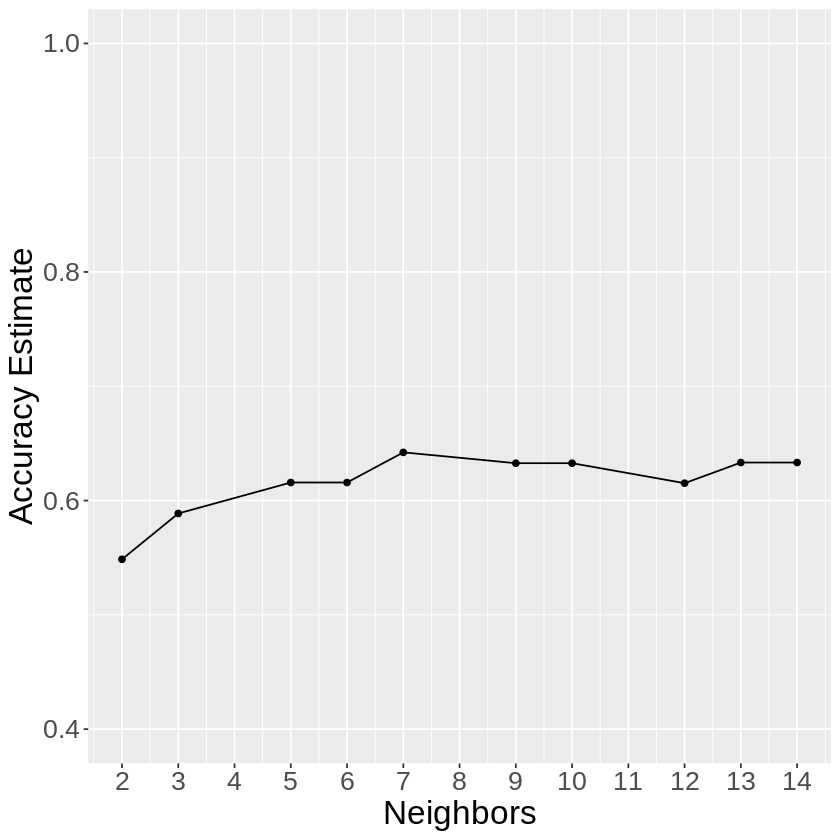

In [10]:
#Displays accuracies 
accuracies <- knn_fit |>
              filter(.metric == "accuracy")
accuracies

#Plot graph to decide which K value is the best by creating a accuracy versus K, shown in Figure 1
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") +
                     theme(text = element_text(size = 20)) +
                     scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                     scale_y_continuous(limits = c(0.4, 1.0))

accuracy_versus_k

Figure 1. Plot of the estimated accuracy versus the number of neighbours. Based on the graph, K = 7 is the best neighbour.

In [11]:
# Creating a model specification using K = 7 neighbours
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
            set_engine("kknn") |>
            set_mode("classification")

# Creating a recipe using the training data
cleveland_recipe_2 <- recipe(diagnosis ~ age + chol, data = cleveland_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

# Combining the specification and recipe into a workflow
cleveland_fit <- workflow() |>
                    add_recipe(cleveland_recipe_2) |>
                    add_model(knn_spec2) |>
                    fit(data = cleveland_train)
cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.380531
Best kernel: rectangular
Best k: 7

age      chol
1 29.00000 126 
2 29.48485 126 
3 29.96970 126 
4 30.45455 126 
5 30.93939 126 
6 31.42424 126

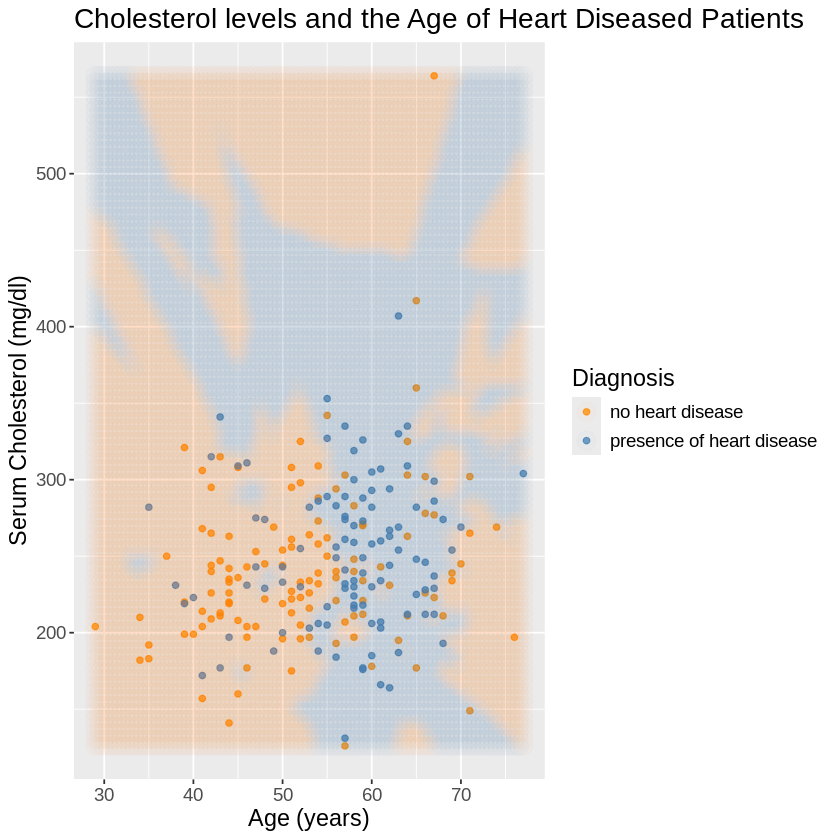

In [13]:
# Create the grid of age and Cholesterol values, arrange in a data frame
age_grid <- seq(min(cleveland_train$age),
                max(cleveland_train$age),
                length.out = 100)
cho_grid <- seq(min(cleveland_train$chol),
                max(cleveland_train$chol),
                length.out = 100)
grid <- as_tibble(expand.grid(age = age_grid,
                                chol = cho_grid))

head(grid)

# Use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(cleveland_fit, grid)


# Bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, grid) |>
  rename(diagnosis = .pred_class)

# Plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
cleveland_plot <-
  ggplot() +
  geom_point(data = cleveland_train,
             mapping = aes(x = age,
                           y = chol,
                           color = diagnosis),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = age,
                           y = chol,
                           color = diagnosis),
             alpha = 0.02,
             size = 5) +
  labs(color = "Diagnosis",
       x = "Age (years)",
       y = "Serum Cholesterol (mg/dl)",
       title = "Cholesterol levels and the Age of Heart Diseased Patients") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 14))

cleveland_plot

Figure 2. Scatterplot of age versus cholesterol levels where the background colour represents the decision of the classifier. We chose scatterplots because it makes it easy to identify the relationship between two variables. We combined all types of patients that share a common characteristic of either having the disease or not. This exploratory analysis will help address our question of “Can age and cholesterol levels be used to predict if an individual has a heart disease?” This is shown by separating the two variables into two colours. These two variables make clear predictors since they visibly show trends of age concerning cholesterol levels. 

## Methods

When wrangling and cleaning the data provided, we selected the relevent columns (1, 5, 14) using the `select` function and renamed them using `rename` to match the data that is being presented; diag represents the diagnosis of heart disease consisting of values of 0 means < 50% diameter narrowing (absence of disease), and 1, 2, and 3 means > 50% diameter narrowing (presence of disease). Cholesterol is in mg/dl and age in years. Using the `head` and `tail` functions, we visualized a portion of the data in table format. We applied `initial_split()` to split our data frame into 75% training data and 25% testing data. We only used the training data for analysis to prevent overfitting. To conduct our data analysis, we plotted the cholesterol levels against the age of the patients using a scatter plot, and then coloured the data points based on the presence of cardiovascular disease in the patient. Using cholesterol as a predictor, we then analyzed the effect that cholesterol levels have on the development of cardiovascular disease. 

## Discussion

In summary, the results from our exploratory data analysis visualization (Fig. 1) showed that there is a weakly positive relationship between high cholesterol levels and age, in terms of the presence of heart disease. It was observed that the majority of data points classified as ‘presence of disease’ (dark blue points) in the patient diagnosis were concentrated towards the upper right corner of the scatterplot, where patients generally aged between 50 years and 70 years, and cholesterol levels were greater than 200 mg/dl. Additionally, the ‘no disease’ patient diagnosis data points (shown in light blue) followed a pattern of being more populated towards the bottom left corner of the scatterplot, where most patients were aged less than 50 years and had lower cholesterol levels relative to the ‘presence of disease’ classified patients. Therefore, we were able to use the Cleveland heart disease dataset from the UC Irvine (UCI) Machine Learning Repository to answer our predictive question “Can age and cholesterol levels be used to predict if an individual has a heart disease”.

This correlation was what we expected to find as prior literature indicated that cholesterol levels greater than 200 mg/dl and increasing age are both important attributes that can predict the presence of heart disease (Karthick et al., 2022).

These such findings highlight the adverse effects of high cholesterol in conjunction with age on the human heart. Thus, these results will hopefully encourage individuals to adopt behaviours conducive to maintaining lower cholesterol levels in their daily lives to lower the possibility of heart disease at a young age.

In conclusion, these findings may lead to important future questions such as ‘What could someone do/avoid to decrease cholesterol levels?’, ‘What other factors may contribute to a higher risk of heart disease?’, and ‘What other short and long-term physical effects can be associated with cholesterol?’.

## Bibliography
Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X

Karthick, K., Aruna, S. K., Samikannu, R., Kuppusamy, R., Teekaraman, Y., & Thelkar, A. R. (2022). Implementation of a Heart Disease Risk Prediction Model Using Machine Learning. Computational and mathematical methods in medicine, 2022, 6517716. https://doi.org/10.1155/2022/6517716